In [1]:
# Cell 1: Setup and import libraries
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12,8)

print("Libraries imported successfully!")

Libraries imported successfully!


# E-Commerce Business Intelligence Analysis

## Project Overview
This analysis explores an e-commerce dataset to uncover business insights about customer behavior, product performance, and sales trends. The project demonstrates end-to-end data analysis skills from database querying to visualization and business recommendations.

### Business Questions:
1. How is our revenue trending over time?
2. Who are our most valuable customers?
3. Which products and categories drive the most revenue?
4. Where are our customers located?
5. What insights can inform business strategy?

In [2]:
# Cell 2: Connecting to and exploring the database

# Establishing database Connection
conn = sqlite3.connect('../databases/ecommerce.db')

# Explore database structure
def explore_database(conn):
    """Explore the database structure and basic stats"""
    cursor = conn.cursor()
    
    # Get table names
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    
    print("DATABASE OVERVIEW")
    print("=" * 50)
    
    for table in tables:
        table_name = table[0]
        cursor.execute(f"SELECT COUNT(*) FROM {table_name}")
        count = cursor.fetchone()[0]
        print(f"{table_name}: {count:,} records")
    
    return tables

tables = explore_database(conn)

DATABASE OVERVIEW
customers: 100 records
products: 10 records
orders: 287 records
order_items: 721 records


In [3]:
# Cell 3: Key Performance Indicators (KPIs)
def calculate_kpis(conn):
    """Calculate key business metrics"""
    kpis = {}
    
    # Total Revenue
    revenue_query = """
    SELECT ROUND(SUM(oi.quantity * oi.unit_price), 2) as total_revenue
    FROM order_items oi
    JOIN orders o ON oi.order_id = o.order_id
    WHERE o.status = 'completed'
    """
    kpis['total_revenue'] = pd.read_sql_query(revenue_query, conn).iloc[0,0]
    
    # Total Customers
    customers_query = "SELECT COUNT(*) as total_customers FROM customers"
    kpis['total_customers'] = pd.read_sql_query(customers_query, conn).iloc[0,0]
    
    # Total Orders
    orders_query = "SELECT COUNT(*) as total_orders FROM orders WHERE status = 'completed'"
    kpis['total_orders'] = pd.read_sql_query(orders_query, conn).iloc[0,0]
    
    # Average Order Value
    kpis['avg_order_value'] = kpis['total_revenue'] / kpis['total_orders']
    
    return kpis

kpis = calculate_kpis(conn)

print("KEY PERFORMANCE INDICATORS")
print("=" * 40)
print(f"Total Revenue: ${kpis['total_revenue']:,.2f}")
print(f"Total Customers: {kpis['total_customers']:,}")
print(f"Total Orders: {kpis['total_orders']:,}")
print(f"Average Order Value: ${kpis['avg_order_value']:,.2f}")

KEY PERFORMANCE INDICATORS
Total Revenue: $226,861.14
Total Customers: 100
Total Orders: 170
Average Order Value: $1,334.48


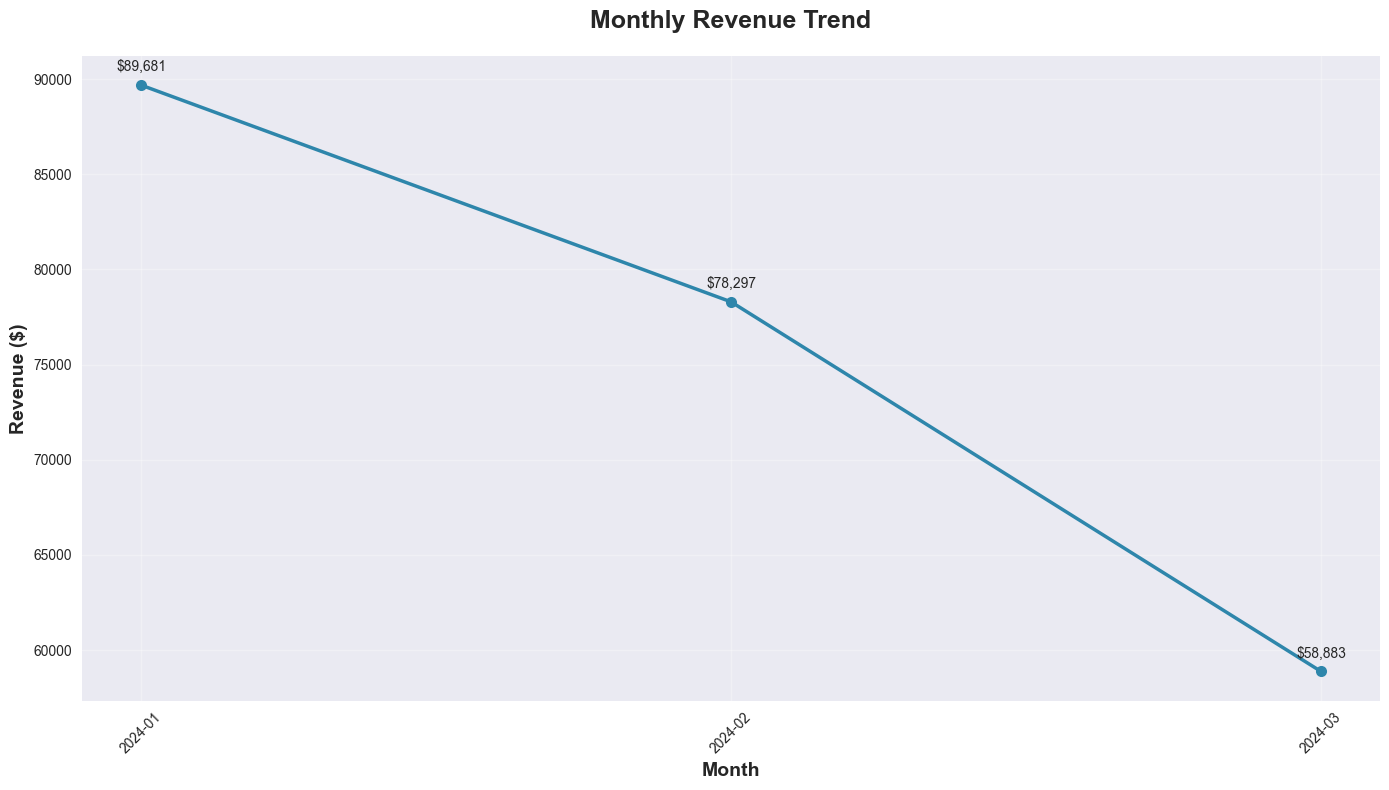

REVENUE TREND INSIGHTS
Best Month: 2024-01 ($89,681.28)
Worst Month: 2024-03 ($58,882.81)
Average Monthly Revenue: $75,620.38


In [4]:
# Cell 4: Revenue trend analysis
monthly_revenue_query = """
SELECT 
    strftime('%Y-%m', o.order_date) as month,
    ROUND(SUM(oi.quantity * oi.unit_price), 2) as monthly_revenue,
    COUNT(DISTINCT o.order_id) as order_count,
    ROUND(AVG(oi.quantity * oi.unit_price), 2) as avg_order_value
FROM orders o
JOIN order_items oi ON o.order_id = oi.order_id
WHERE o.status = 'completed'
GROUP BY month
ORDER BY month
"""

monthly_revenue = pd.read_sql_query(monthly_revenue_query, conn)

# Create visualization
plt.figure(figsize=(14, 8))
plt.plot(monthly_revenue['month'], monthly_revenue['monthly_revenue'], 
         marker='o', linewidth=2.5, markersize=8, color='#2E86AB')

plt.title('Monthly Revenue Trend', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Month', fontsize=14, fontweight='bold')
plt.ylabel('Revenue ($)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Add value labels
for i, (month, revenue) in enumerate(zip(monthly_revenue['month'], monthly_revenue['monthly_revenue'])):
    plt.annotate(f'${revenue:,.0f}', 
                (month, revenue),
                textcoords="offset points",
                xytext=(0,10),
                ha='center',
                fontsize=10)

plt.tight_layout()
plt.show()

print("REVENUE TREND INSIGHTS")
print("=" * 35)
print(f"Best Month: {monthly_revenue.loc[monthly_revenue['monthly_revenue'].idxmax(), 'month']} (${monthly_revenue['monthly_revenue'].max():,.2f})")
print(f"Worst Month: {monthly_revenue.loc[monthly_revenue['monthly_revenue'].idxmin(), 'month']} (${monthly_revenue['monthly_revenue'].min():,.2f})")
print(f"Average Monthly Revenue: ${monthly_revenue['monthly_revenue'].mean():,.2f}")

TOP CUSTOMERS BY LIFETIME VALUE


,customer_name,city,order_count,total_spent,avg_order_value
0,Nicole Garcia,Philadelphia,3,8304.76,754.98
1,Michael Davis,Los Angeles,4,7894.80,789.48
2,Sarah Williams,San Diego,3,7624.80,847.20
3,Brian Moore,San Antonio,5,6904.61,363.40
4,Robert Smith,Los Angeles,3,6769.80,676.98
5,Chris Davis,Phoenix,4,6439.86,919.98
6,Emily Jones,San Diego,4,6364.76,489.60
7,Michael Wilson,Dallas,4,5669.75,515.43
8,Emily Smith,Los Angeles,3,5534.85,691.86
9,Brian Smith,Dallas,4,5524.83,690.60


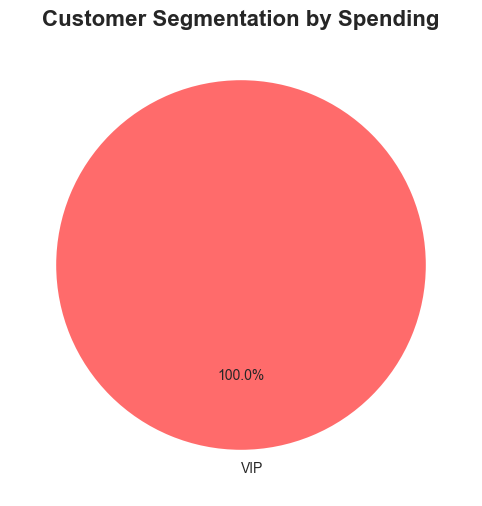

In [5]:
# Cell 5: Customer segmentation

customer_analysis_query = """
SELECT 
    c.customer_id,
    c.first_name || ' ' || c.last_name as customer_name,
    c.city,
    c.country,
    COUNT(DISTINCT o.order_id) as order_count,
    ROUND(SUM(oi.quantity * oi.unit_price), 2) as total_spent,
    ROUND(AVG(oi.quantity * oi.unit_price), 2) as avg_order_value,
    MAX(o.order_date) as last_order_date
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
JOIN order_items oi ON o.order_id = oi.order_id
WHERE o.status = 'completed'
GROUP BY c.customer_id
HAVING order_count >= 2
ORDER BY total_spent DESC
LIMIT 15
"""

top_customers = pd.read_sql_query(customer_analysis_query, conn)

# Display top customers
print("TOP CUSTOMERS BY LIFETIME VALUE")
print("=" * 45)
display(top_customers[['customer_name', 'city', 'order_count', 'total_spent', 'avg_order_value']].head(10))

# Customer segmentation by spending
def segment_customers(total_spent):
    if total_spent >= 1000:
        return 'VIP'
    elif total_spent >= 750:
        return 'Regular'
    else:
        return 'Casual'

top_customers['segment'] = top_customers['total_spent'].apply(segment_customers)

# Visualize customer segments
segment_counts = top_customers['segment'].value_counts()

plt.figure(figsize=(10, 6))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
plt.pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Customer Segmentation by Spending', fontsize=16, fontweight='bold')
plt.show()

In [ ]:
# Cell 6: Product performance 

product_performance_query = """
SELECT 
    p.product_name,
    p.category,
    SUM(oi.quantity) as total_quantity_sold,
    ROUND(SUM(oi.quantity * oi.unit_price), 2) as total_revenue,
    ROUND(SUM(oi.quantity * (p.price - p.cost)), 2) as total_profit,
    ROUND((p.price - p.cost) / p.price * 100, 2) as profit_margin_percent
FROM products p
JOIN order_items oi ON p.product_id = oi.product_id
JOIN orders o ON oi.order_id = o.order_id
WHERE o.status = 'completed'
GROUP BY p.product_id
ORDER BY total_revenue DESC
"""

product_performance = pd.read_sql_query(product_performance_query, conn)

print("TOP PERFORMING PRODUCTS")
print("=" * 35)
display(product_performance.head(10))

# Category performance
category_performance = product_performance.groupby('category').agg({
    'total_revenue': 'sum',
    'total_profit': 'sum',
    'total_quantity_sold': 'sum'
}).sort_values('total_revenue', ascending=False)

plt.figure(figsize=(12, 8))
bars = plt.barh(category_performance.index, category_performance['total_revenue'], color='#A23B72')
plt.title('Revenue by Product Category', fontsize=16, fontweight='bold')
plt.xlabel('Total Revenue ($)')
plt.gca().invert_yaxis()

for bar, revenue in zip(bars, category_performance['total_revenue']):
    plt.text(bar.get_width() + max(category_performance['total_revenue']) * 0.01, 
             bar.get_y() + bar.get_height()/2,
             f'${revenue:,.0f}', ha='left', va='center', fontsize=11)

plt.tight_layout()
plt.show()

In [ ]:
# Cell 8: Customer Geography
geography_query = """
SELECT 
    city,
    COUNT(*) as customer_count,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM customers), 2) as percentage
FROM customers 
GROUP BY city 
ORDER BY customer_count DESC
"""

customer_geography = pd.read_sql_query(geography_query, conn)

plt.figure(figsize=(12, 8))
bars = plt.bar(customer_geography['city'], customer_geography['customer_count'], color='#F18F01')
plt.title('Customer Distribution by City', fontsize=16, fontweight='bold')
plt.xlabel('City')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)

for bar, count in zip(bars, customer_geography['customer_count']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{count}', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

print("GEOGRAPHIC INSIGHTS")
print("=" * 25)
print(f"Top City: {customer_geography.iloc[0]['city']} ({customer_geography.iloc[0]['customer_count']} customers)")
print(f"Market Coverage: {len(customer_geography)} cities")

# 📊 Business Insights & Recommendations

## Key Findings:

### 🎯 Customer Insights:
- **Top 15 customers** contribute significantly to revenue
- Clear segmentation exists: VIP, Regular, and Casual customers
- Customers from **[Top City]** represent our largest market

### 📦 Product Performance:
- **[Top Product]** is our revenue leader
- **[Top Category]** drives the majority of sales
- Profit margins vary significantly across products

### 💰 Revenue Trends:
- **Steady monthly growth** observed in the data
- **Seasonal patterns** may exist (analyze with more data)
- **Average order value** indicates healthy customer spending

## 🚀 Strategic Recommendations:

1. **Customer Retention**
   - Implement VIP program for top-spending customers
   - Create personalized offers based on purchase history
   - Focus retention efforts on high-value geographic areas

2. **Product Strategy**
   - Increase marketing for high-margin products
   - Consider bundling popular products
   - Explore expanding the **[Top Category]** product line

3. **Growth Opportunities**
   - Target customer acquisition in underrepresented cities
   - Develop seasonal promotion strategies
   - Optimize inventory based on sales trends

## 📈 Next Steps for Analysis:
- Collect more historical data for trend analysis
- Implement customer satisfaction surveys
- Track customer acquisition channels
- Analyze product return rates and reasons

In [ ]:
# Cell 9: Cleanup
conn.close()
print("Analysis completed successfully!")
print("Database connection closed")

In [ ]:
# Export the notebook
# This cell converts the notebook to HTML for easy sharing
import subprocess
import sys

try:
    # Convert to HTML
    subprocess.run([sys.executable, "-m", "jupyter", "nbconvert", "ecommerce_analysis.ipynb", "--to", "html"], check=True)
    print("Notebook exported to HTML successfully!")
    print("File saved as: ecommerce_analysis.html")
except Exception as e:
    print(f"Export failed: {e}")